Total Pairs: 50886
Training Pairs: 45797
Validation Pairs: 5089

Training CTPE (Cross-Encoder) Logistic Regression Model...

Evaluating Baseline (Bi-Encoder) Model...
Baseline - Accuracy: 0.5017, F1 Score: 0.0000

Evaluating CTPE (Cross-Encoder) Model...
CTPE - Accuracy: 0.1466, F1 Score: 0.1486

Plotting ROC Curve for Baseline (Bi-Encoder)...


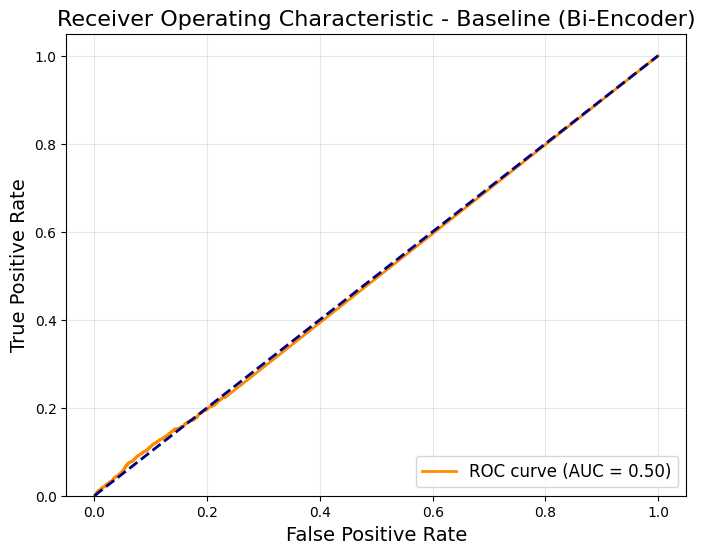


Plotting ROC Curve for CTPE (Cross-Encoder)...


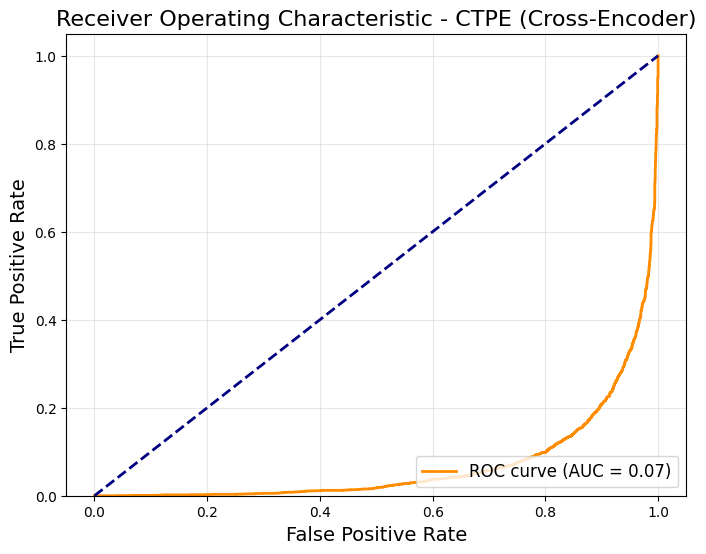

In [ ]:
import pandas as pd
import numpy as np
import torch  # Not strictly necessary for this model but kept for consistency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# 1. Data Preparation
# -----------------------------

# Load your dataset
df = pd.read_csv("/data2/home/rohitsunil/termreport/arxiv_new.csv")
df = df.rename(columns={'summary': 'abstract'})

# Create positive pairs
positive_pairs = df[['title', 'abstract']].copy()
positive_pairs['label'] = 1

# Create negative pairs by shuffling abstracts
negative_pairs = df[['title', 'abstract']].copy()
negative_pairs = negative_pairs.sample(frac=1, random_state=42).reset_index(drop=True)
negative_pairs['label'] = 0

# Combine positive and negative pairs
all_pairs = pd.concat([positive_pairs, negative_pairs], ignore_index=True)

# Shuffle the combined pairs
all_pairs = all_pairs.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into training and validation sets (90% train, 10% validation)
train_pairs, val_pairs = train_test_split(all_pairs, test_size=0.1, random_state=42)

print(f"Total Pairs: {len(all_pairs)}")
print(f"Training Pairs: {len(train_pairs)}")
print(f"Validation Pairs: {len(val_pairs)}")

# -----------------------------
# 2. Feature Extraction
# -----------------------------

# Baseline (Bi-Encoder): TF-IDF for titles and abstracts separately
tfidf_title = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
tfidf_abstract = TfidfVectorizer(max_features=5000)

# Fit on training data
tfidf_title.fit(train_pairs['title'])
tfidf_abstract.fit(train_pairs['abstract'])

# Transform training and validation data
X_train_title = tfidf_title.transform(train_pairs['title'])
X_train_abstract = tfidf_abstract.transform(train_pairs['abstract'])

X_val_title = tfidf_title.transform(val_pairs['title'])
X_val_abstract = tfidf_abstract.transform(val_pairs['abstract'])

# Compute cosine similarity for Baseline
def compute_cosine_similarity(X1, X2):
    """
    Computes cosine similarity between two TF-IDF matrices.
    
    Args:
        X1 (sparse matrix): TF-IDF features for titles.
        X2 (sparse matrix): TF-IDF features for abstracts.
        
    Returns:
        np.ndarray: Array of cosine similarity scores.
    """
    # Normalize the TF-IDF vectors
    X1_norm = normalize(X1, norm='l2')
    X2_norm = normalize(X2, norm='l2')
    
    # Compute element-wise cosine similarity
    cosine_sim = X1_norm.multiply(X2_norm).sum(axis=1).A1  # .A1 converts to 1D array
    return cosine_sim

# Compute similarity scores
train_baseline_sim = compute_cosine_similarity(X_train_title, X_train_abstract)
val_baseline_sim = compute_cosine_similarity(X_val_title, X_val_abstract)

# CTPE (Cross-Encoder): TF-IDF for concatenated title and abstract
tfidf_ctpe = TfidfVectorizer(max_features=10000)  # More features since input is concatenated

# Create concatenated texts
train_pairs['concatenated'] = train_pairs['title'] + " [SEP] " + train_pairs['abstract']
val_pairs['concatenated'] = val_pairs['title'] + " [SEP] " + val_pairs['abstract']

# Fit TF-IDF on concatenated training data
tfidf_ctpe.fit(train_pairs['concatenated'])

# Transform concatenated texts
X_train_ctpe = tfidf_ctpe.transform(train_pairs['concatenated'])
X_val_ctpe = tfidf_ctpe.transform(val_pairs['concatenated'])

# -----------------------------
# 3. Model Training
# -----------------------------

# Baseline (Bi-Encoder): No training needed, using cosine similarity directly

# CTPE (Cross-Encoder): Train Logistic Regression
lr_ctpe = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

# Train the classifier
print("\nTraining CTPE (Cross-Encoder) Logistic Regression Model...")
lr_ctpe.fit(X_train_ctpe, train_pairs['label'])

# -----------------------------
# 4. Model Evaluation
# -----------------------------

# Baseline Evaluation
print("\nEvaluating Baseline (Bi-Encoder) Model...")
val_labels_baseline = val_pairs['label'].values
val_predictions_baseline = (val_baseline_sim >= 0.5).astype(int)
val_accuracy_baseline = accuracy_score(val_labels_baseline, val_predictions_baseline)
val_f1_baseline = f1_score(val_labels_baseline, val_predictions_baseline)
print(f"Baseline - Accuracy: {val_accuracy_baseline:.4f}, F1 Score: {val_f1_baseline:.4f}")

# CTPE Evaluation
print("\nEvaluating CTPE (Cross-Encoder) Model...")
val_labels_ctpe = val_pairs['label'].values
val_predictions_ctpe = lr_ctpe.predict(X_val_ctpe)
val_prob_ctpe = lr_ctpe.predict_proba(X_val_ctpe)[:, 1]  # Probability of class 1

val_accuracy_ctpe = accuracy_score(val_labels_ctpe, val_predictions_ctpe)
val_f1_ctpe = f1_score(val_labels_ctpe, val_predictions_ctpe)
print(f"CTPE - Accuracy: {val_accuracy_ctpe:.4f}, F1 Score: {val_f1_ctpe:.4f}")



